In [165]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import butter, sosfilt, stft, welch
from scipy.optimize import curve_fit
import scipy.io as sio

## Determine the charge state of the nanosphere

In [124]:
drive_freq = 69000
data_file = r"C:\Users\yuhan\Documents\Data\charging\20240401_lockin.csv"
data = np.genfromtxt(data_file, delimiter=',', skip_header=3).T

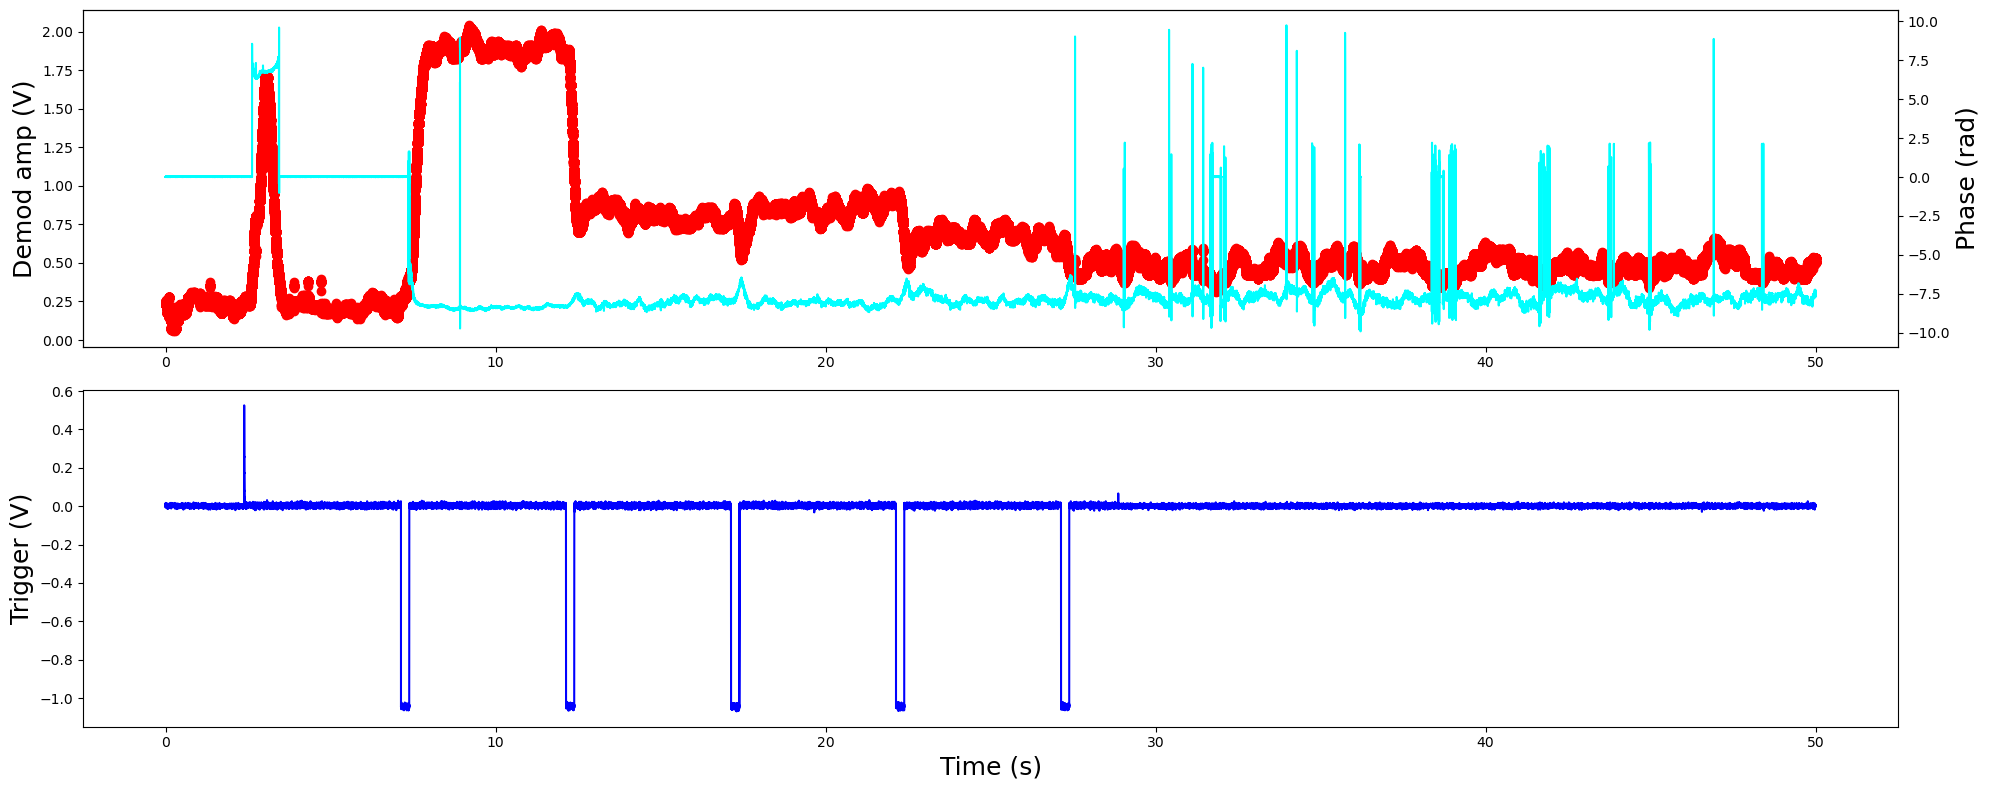

In [126]:
fig, ax = plt.subplots(2, 1, figsize = (20, 8))
ax_twin = ax[0].twinx()

ax[0].plot(data[0], data[1], 'r.', markersize=12)
ax[1].plot(data[0], data[3], 'b')

ax_twin.plot(data[0], data[2], 'cyan')
ax_twin.set_ylabel('Phase (rad)', fontsize=18)
ax_twin.tick_params(axis='y', color='k')

ax[0].set_ylabel('Demod amp (V)', fontsize=18)
ax[1].set_xlabel('Time (s)', fontsize=18)
ax[1].set_ylabel('Trigger (V)', fontsize=18)

fig.tight_layout()
plt.show()

There is 1e charge on the sphere.

## Thermal calibration of another sphere

I believe this sphere has 2e charges

In [156]:
drive_freq = 69000
data_file = r"C:\Users\yuhan\Documents\Data\charging\20240401_nohv_20vp2p_1mbar_2.csv"
data = np.genfromtxt(data_file, delimiter=',', skip_header=3).T

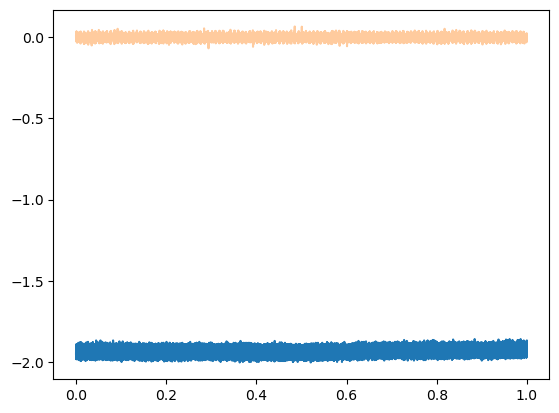

In [157]:
plt.plot(data[0], data[1])
plt.plot(data[0], data[2], alpha=0.4)

In [158]:
def peak_func(x, amp, omega_0, gamma):
    """A Lorentzian line shape"""
    return amp * gamma / ( ( omega_0**2 - x**2)**2 + gamma**2 * x**2 )

def fit_peak(x, y, peak_func, p0=None):
    popt, pcov = curve_fit(peak_func, x, y, p0=p0)
    
    # Return central frequency and gamma
    return popt, x, peak_func(x, *popt)

In [159]:
fs = int(np.ceil(1 / (data[0, 1] - data[0, 0])))
nperseg = fs / 10
ff, pp = welch(data[1], fs=fs, nperseg=nperseg)

Amplitude: 56155208.365583256, central frequency: 68068.65142003814 Hz, gamma: 2468.0747578930814 Hz


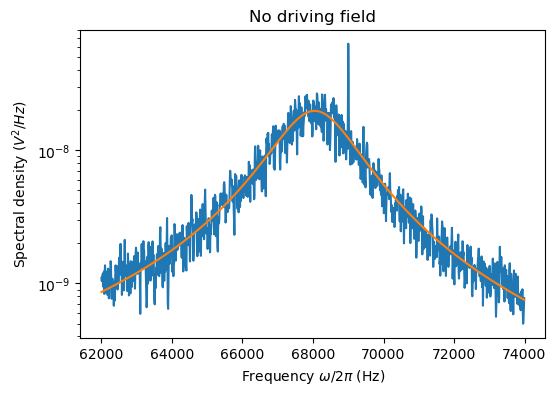

In [160]:
lb, ub = 6200, 7400

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(ff[lb:ub], pp[lb:ub])

# Fit with a Lorentzian and plot
popt, omega_fit, p_fit = fit_peak(ff[lb:ub]*2*np.pi, pp[lb:ub], peak_func, p0=[5e7, 67000*2*np.pi, 8000])
ax.plot(omega_fit/(2*np.pi), p_fit)

amp, omega0, gamma = popt[0], popt[1], popt[2]
print(f'Amplitude: {amp}, central frequency: {omega0/(2*np.pi)} Hz, gamma: {gamma/(2*np.pi)} Hz')

ax.set_title('No driving field')
ax.set_xlabel('Frequency $\omega / 2 \pi$ (Hz)')
ax.set_ylabel('Spectral density ($V^2 / Hz$)')
ax.set_yscale('log')

In [161]:
T   = 300  # K
kb  = 1.38e-23

# Use this value after ethanol is gone
rho = 2000 # kg/m^3
r   = 167e-9 / 2
m   = rho * (4 * np.pi / 3) * r**3 

# Again need to take care of 2 pi normalization
# because the formula assume integrating over `omega`, not `f`
v2 = 0.5 * np.pi/(gamma * omega0**2) * amp * gamma / (2 * np.pi)

# Calibration factor converting <V^2> to (x^2)
c_cal_square = (v2 * m * omega0**2) / (kb * T)
print(fr'Calibration factor square $c^2$: {c_cal_square}')

Calibration factor square $c^2$: 16538942679.007523


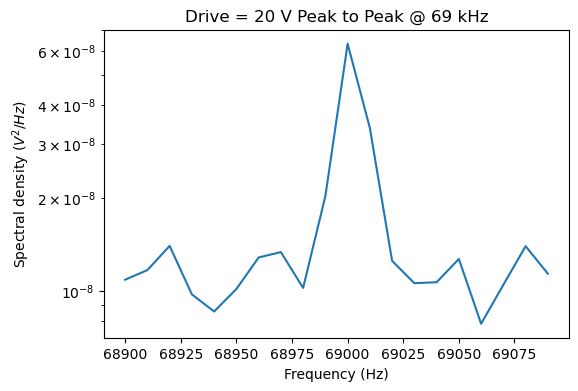

In [162]:
lb, ub = 6890, 6910

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(ff[lb:ub], pp[lb:ub])

ax.set_title(f'Drive = 20 V Peak to Peak @ {int(drive_freq/1000)} kHz')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Spectral density ($V^2 / Hz$)')

ax.set_yscale('log')

In [163]:
all_idx = np.arange(lb, ub, 1)
excluding_peak = np.logical_or(all_idx < (lb+7), all_idx > (ub-7))

area_all = np.trapz(pp[all_idx], ff[all_idx]*2*np.pi)
area_excluding_peak = np.trapz( pp[all_idx[excluding_peak]], ff[all_idx[excluding_peak]]*2*np.pi )

# Excluding background contribution (which is very small)
# Take care of 2 pi normalization after numerical integration
# because we integrated over omega here
v2_drive = (area_all - area_excluding_peak) / (2 * np.pi)

In [164]:
vp2p = 20
omega_drive = drive_freq * 2 * np.pi

x2_drive = v2_drive / c_cal_square
f_amp_squared = x2_drive * 2 * m**2 * ( (omega0**2 - omega_drive**2)**2 + gamma**2 * omega_drive**2)

charge = np.sqrt(f_amp_squared) / (1.6e-19 * 120 * (vp2p / 2))
print(f'Charge on the sphere derived through a driving E field: +/- {charge:.2f} e')

Charge on the sphere derived through a driving E field: +/- 2.12 e


## Determine optimal PLL phases

In [237]:
def get_area_psd(phi, prefix, nfile, channel='C', passband=(60000, 80000)):
    areas = np.empty(nfile, dtype=np.float32)
    
    for i in range(nfile):
        fname = f"{prefix}{prefix2}{phi}{prefix2}{phi}_{i+1:02d}.mat"
        data = sio.loadmat(fname)
        
        fs = int(np.floor(1 / data['Tinterval'][0, 0]))
        nperseg = fs / 10
        ff, pp = welch(data[channel][:,0], fs=fs, nperseg=nperseg)
        idx = np.logical_and(ff > passband[0], ff < passband[1])

        areas[i] = np.trapz(pp[idx], ff[idx])

    area, std_area = np.mean(areas), np.std(areas)
    return area, std_area

#### Z scan

Text(0.5, 0, 'Phase (deg)')

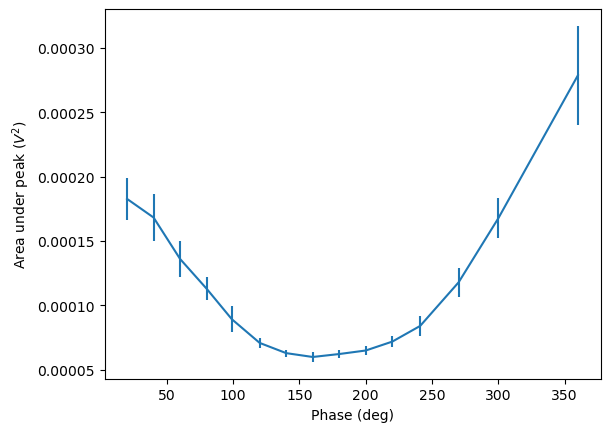

In [235]:
phiphi = [20, 40, 60, 80, 99, 120, 140, 160, 180, 200, 220, 241, 270, 300, 360]

prefix = r"C:\Users\yuhan\Documents\Data\cooling"
prefix2 = r"\20240401_zscan_phase"
nfile = 15

area_phi = np.empty(len(phiphi), dtype=np.float32)
std_area_phi = np.empty(len(phiphi), dtype=np.float32)
for i, phi in enumerate(phiphi):
    area, std_area = get_area_psd(phi, prefix, nfile, 'C', (60e3, 80e3))
    area_phi[i] = area
    std_area_phi[i] = std_area

plt.errorbar(phiphi, area_phi, std_area_phi)
plt.ylabel('Area under peak ($V^2$)')
plt.xlabel('Phase (deg)')

#### Y scan (although the file name says X scan...)

Text(0.5, 0, 'Phase (deg)')

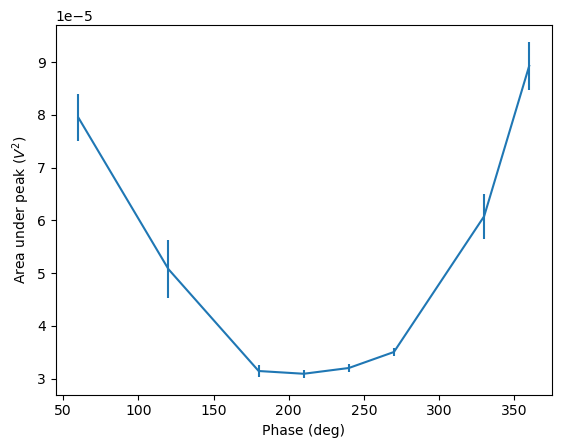

In [240]:
phiphi = [60, 120, 180, 210, 240, 270, 330, 360]

prefix = r"C:\Users\yuhan\Documents\Data\cooling"
prefix2 = r"\20240401_xscan_phase"
nfile = 15

area_phi = np.empty(len(phiphi), dtype=np.float32)
std_area_phi = np.empty(len(phiphi), dtype=np.float32)
for i, phi in enumerate(phiphi):
    area, std_area = get_area_psd(phi, prefix, nfile, 'A', (320e3, 400e3))
    area_phi[i] = area
    std_area_phi[i] = std_area

plt.errorbar(phiphi, area_phi, std_area_phi)
plt.ylabel('Area under peak ($V^2$)')
plt.xlabel('Phase (deg)')

#### X scan

Text(0.5, 0, 'Phase (deg)')

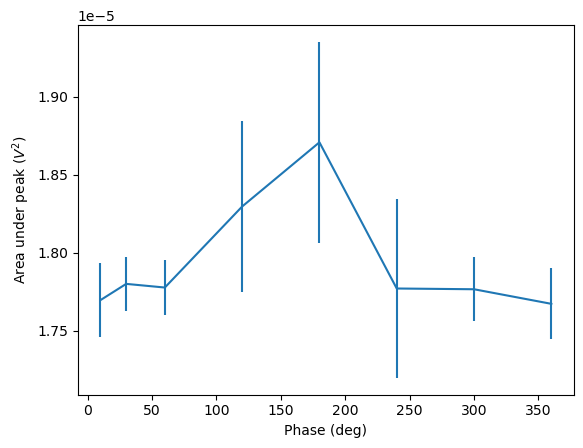

In [245]:
phiphi = [10, 30, 60, 120, 180, 240, 300, 360]

prefix = r"C:\Users\yuhan\Documents\Data\cooling"
prefix2 = r"\20240401_yscan_phase"
nfile = 15

area_phi = np.empty(len(phiphi), dtype=np.float32)
std_area_phi = np.empty(len(phiphi), dtype=np.float32)
for i, phi in enumerate(phiphi):
    area, std_area = get_area_psd(phi, prefix, nfile, 'B', (225e3, 275e3))
    area_phi[i] = area
    std_area_phi[i] = std_area

plt.errorbar(phiphi, area_phi, std_area_phi)
plt.ylabel('Area under peak ($V^2$)')
plt.xlabel('Phase (deg)')

## Continue on April 02

Text(0.5, 0, 'Phase (deg)')

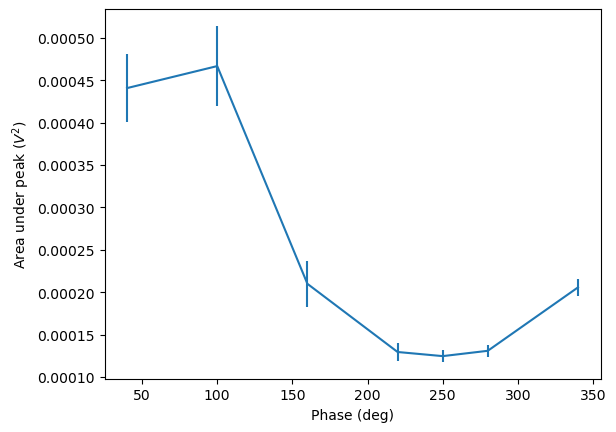

In [248]:
phiphi = [40, 100, 160, 220, 250, 280, 340]

prefix = r"C:\Users\yuhan\Documents\Data\cooling\20240402_scan"
prefix2 = r"\20240402_zscan_phase"
nfile = 15

area_phi = np.empty(len(phiphi), dtype=np.float32)
std_area_phi = np.empty(len(phiphi), dtype=np.float32)
for i, phi in enumerate(phiphi):
    area, std_area = get_area_psd(phi, prefix, nfile, 'C', (60e3, 80e3))
    area_phi[i] = area
    std_area_phi[i] = std_area

plt.errorbar(phiphi, area_phi, std_area_phi)
plt.ylabel('Area under peak ($V^2$)')
plt.xlabel('Phase (deg)')

Text(0.5, 0, 'Phase (deg)')

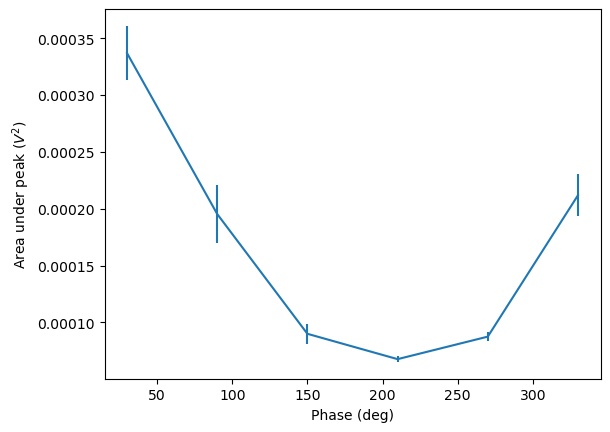

In [250]:
phiphi = [30, 90, 150, 210, 270, 330]

prefix = r"C:\Users\yuhan\Documents\Data\cooling\20240402_scan"
prefix2 = r"\20240402_xscan_phase"
nfile = 15

area_phi = np.empty(len(phiphi), dtype=np.float32)
std_area_phi = np.empty(len(phiphi), dtype=np.float32)
for i, phi in enumerate(phiphi):
    area, std_area = get_area_psd(phi, prefix, nfile, 'A', (320e3, 400e3))
    area_phi[i] = area
    std_area_phi[i] = std_area

plt.errorbar(phiphi, area_phi, std_area_phi)
plt.ylabel('Area under peak ($V^2$)')
plt.xlabel('Phase (deg)')

Text(0.5, 0, 'Phase (deg)')

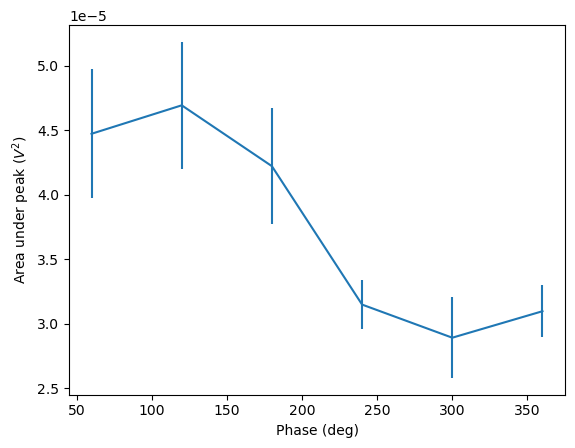

In [252]:
phiphi = [60, 120, 180, 240, 300, 360]

prefix = r"C:\Users\yuhan\Documents\Data\cooling\20240402_scan"
prefix2 = r"\20240402_yscan_phase"
nfile = 15

area_phi = np.empty(len(phiphi), dtype=np.float32)
std_area_phi = np.empty(len(phiphi), dtype=np.float32)
for i, phi in enumerate(phiphi):
    area, std_area = get_area_psd(phi, prefix, nfile, 'B', (260e3, 290e3))
    area_phi[i] = area
    std_area_phi[i] = std_area

plt.errorbar(phiphi, area_phi, std_area_phi)
plt.ylabel('Area under peak ($V^2$)')
plt.xlabel('Phase (deg)')